<a href="https://colab.research.google.com/github/ValentinoMalakianno/PCVK_2023/blob/main/UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TI 3G - UAS PCVK**

**KELOMPOK 2**

Farhan Ramazain

Ilham Khalis

Muhammad Bagas

Valentino Malakianno

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import zipfile
import re
import cv2
import random
import os
from PIL import Image
import subprocess
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Image Pre-processing**

In [52]:
directory = '/content/drive/MyDrive/PCVK/UAS'
image_files = [file for file in os.listdir(directory) if file.endswith((".jpg", ".jpeg"))]

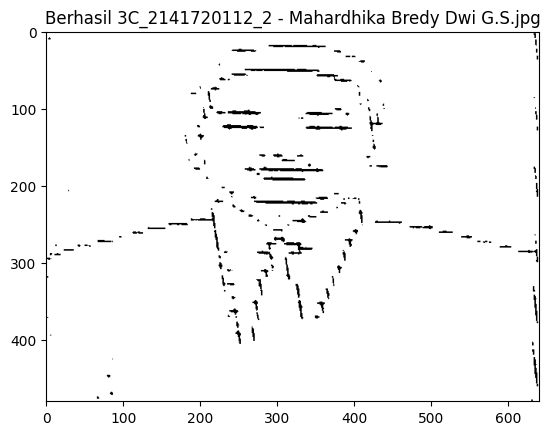

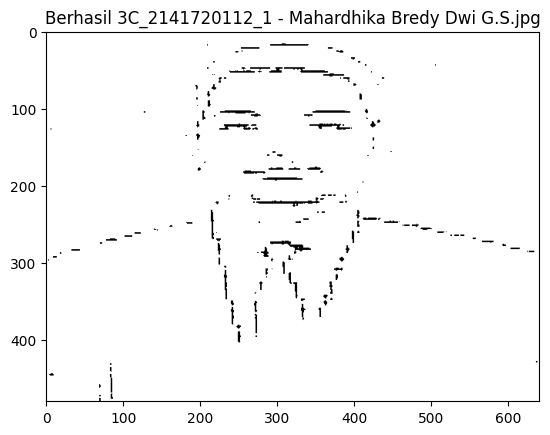

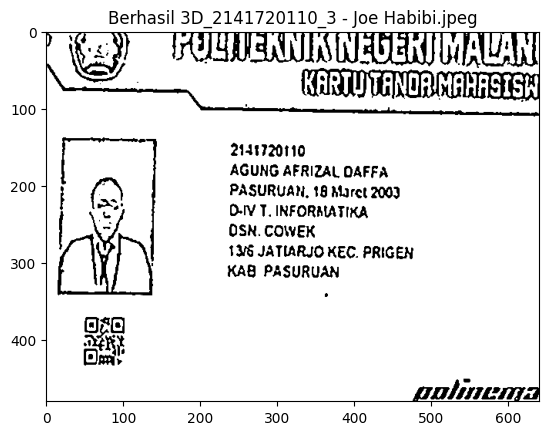

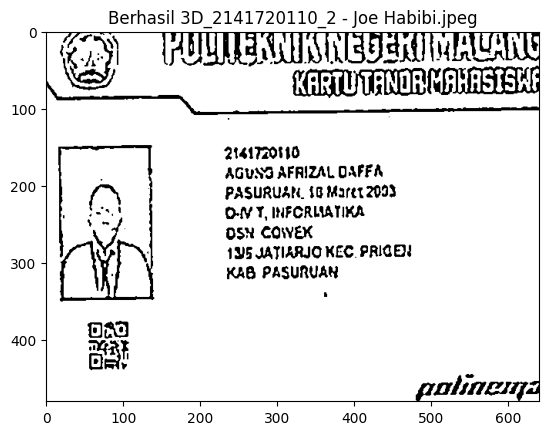

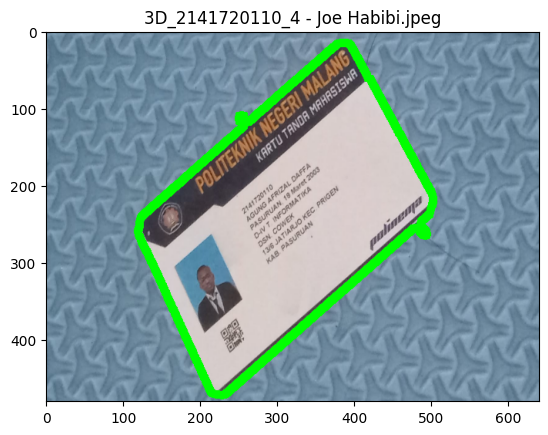

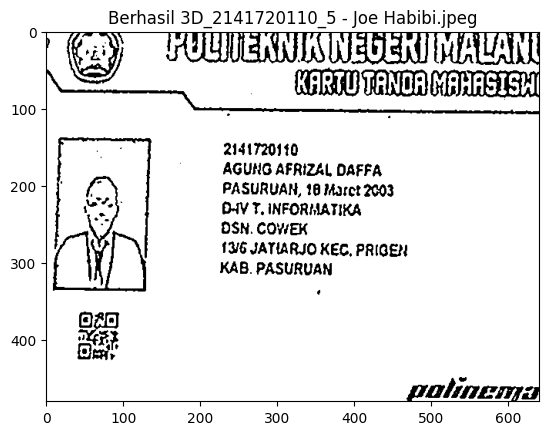

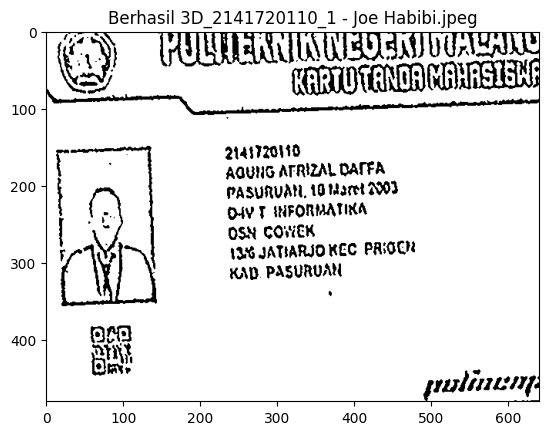

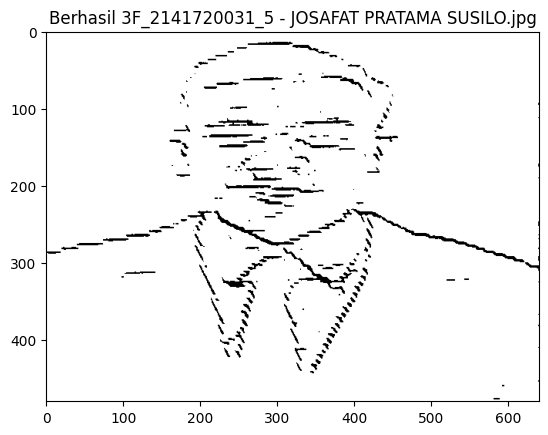

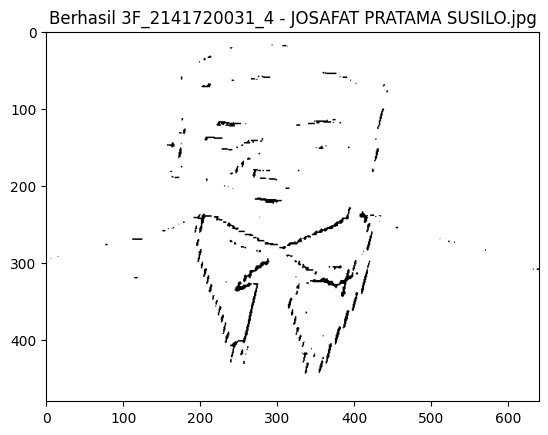

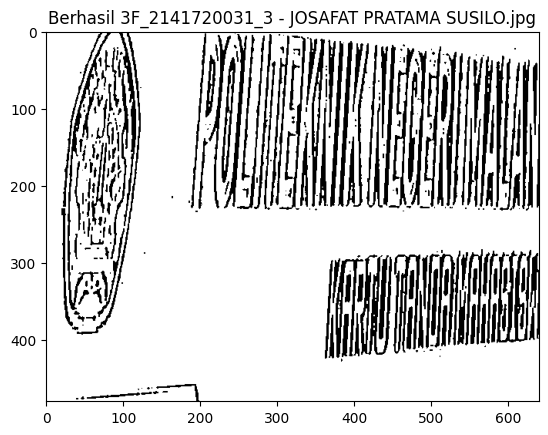

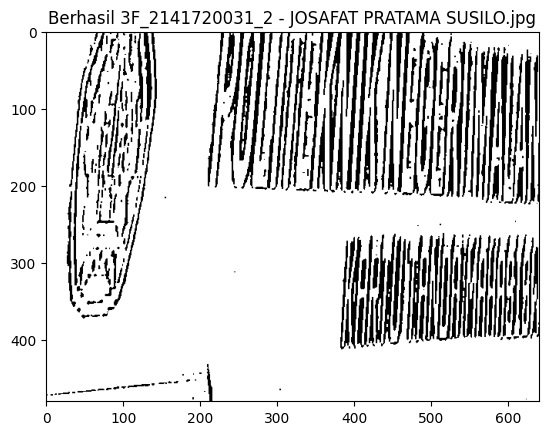

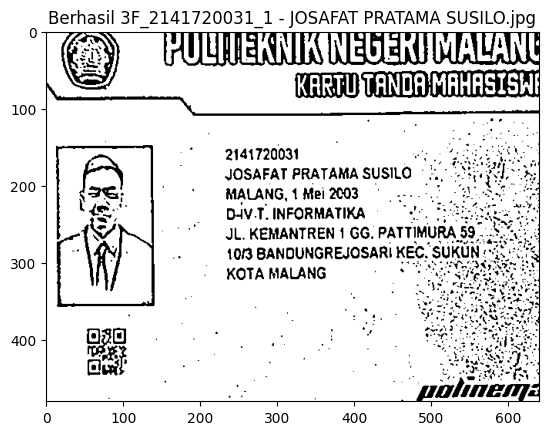

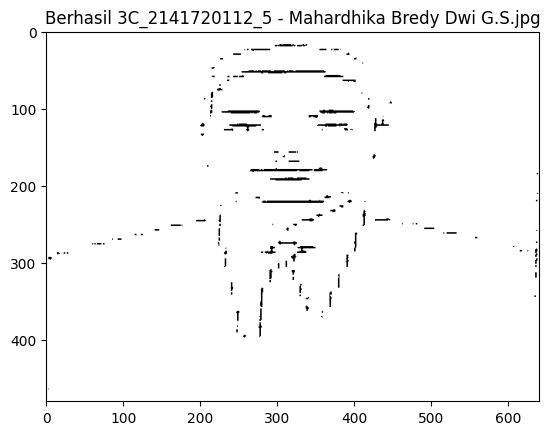

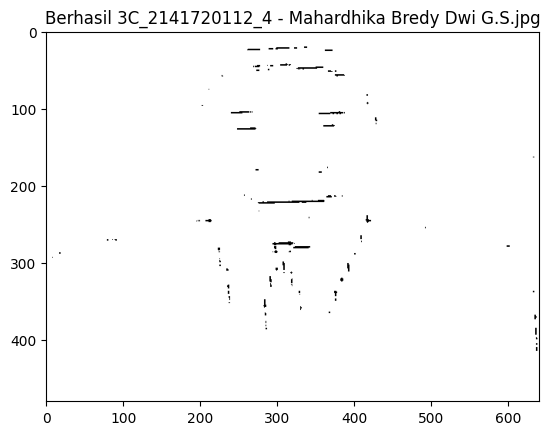

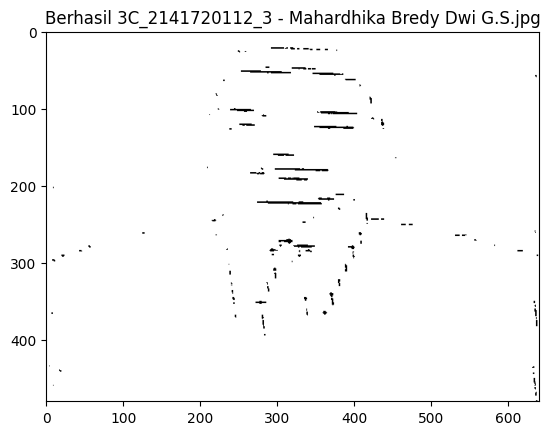

In [53]:
successful_images = []

for image_file in image_files:
  image_path = os.path.join(directory, image_file)
  def nothing(x):
    pass

  def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
      area = cv2.contourArea(i)
      if area > 5000:
        peri = cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
          biggest = approx
          max_area = area
    return biggest, max_area

  def drawRectangle(img,biggest,thickness):
      cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)

  def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

  widthImg = 640
  heightImg = 480
  img = cv2.imread(image_path)
  img = cv2.resize(img,(widthImg, heightImg))
  imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)

  median = np.median(imgBlur)

  # Set lower and upper thresholds based on the median value
  lower_threshold = int(max(0, 0.7 * median))
  upper_threshold = int(min(255, 1.3 * median))
  imgThreshold = cv2.Canny(imgBlur, lower_threshold, upper_threshold)
  kernel = np.ones((5,5))
  imgDilation = cv2.dilate(imgThreshold, kernel, iterations=2)
  imgThreshold = cv2.erode(imgDilation, kernel, iterations=1)
  imgContours = img.copy()
  imgBigContour = img.copy()
  contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(imgContours, contours, -1, (0,255,0), 10)

  biggest, maxArea = biggestContour(contours)
  if biggest.size != 0:
    biggest = reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0,255,0), 20)
    imgBigContour = drawRectangle(imgBigContour, biggest, 2)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    # kurangi 20pixel setiap sisi
    imgWarpColored = imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]
    imgWarpColored = cv2.resize(imgWarpColored, (widthImg, heightImg))
    #adaptive threshold
    imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
    imgAdaptiveThre = cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2)
    imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
    imgAdaptiveThre = cv2.medianBlur(imgAdaptiveThre,3)

    successful_images.append(imgAdaptiveThre)

    plt.figure()
    imgAdaptiveThre_rgb = cv2.cvtColor(imgAdaptiveThre, cv2.COLOR_GRAY2RGB)
    plt.imshow(imgAdaptiveThre_rgb)
    plt.title('Berhasil '+image_file)

  else:
    plt.figure()
    imgContours_rgb = cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB)
    plt.imshow(imgContours_rgb)
    plt.title(image_file)
plt.show()

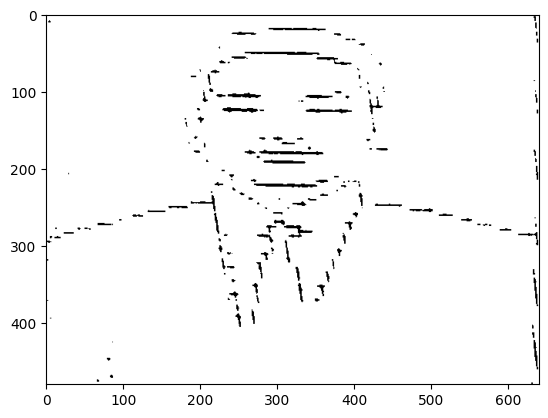

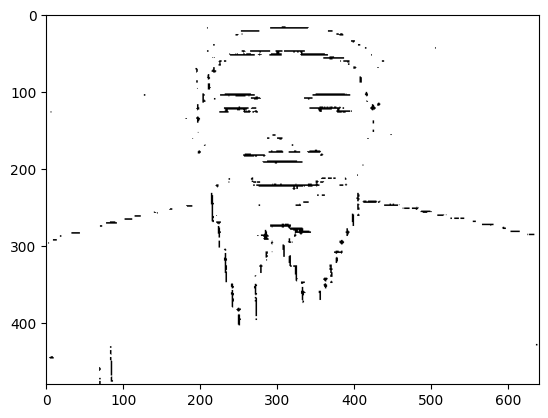

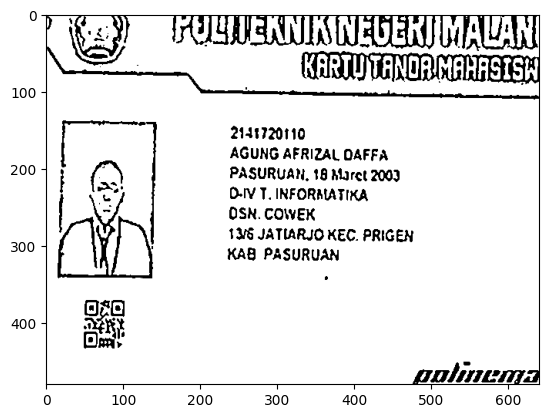

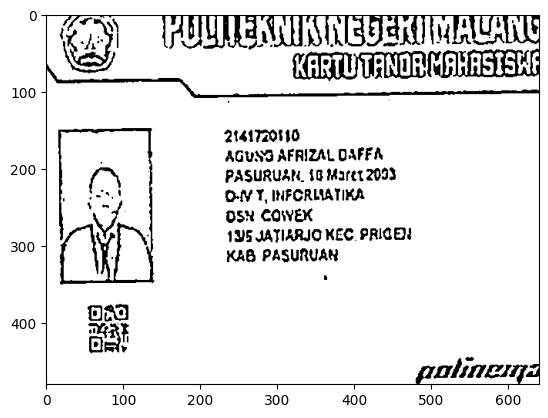

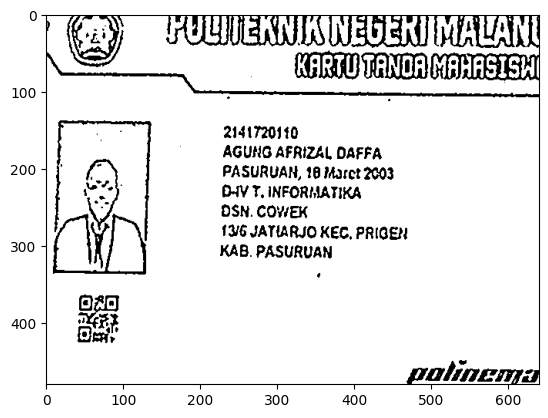

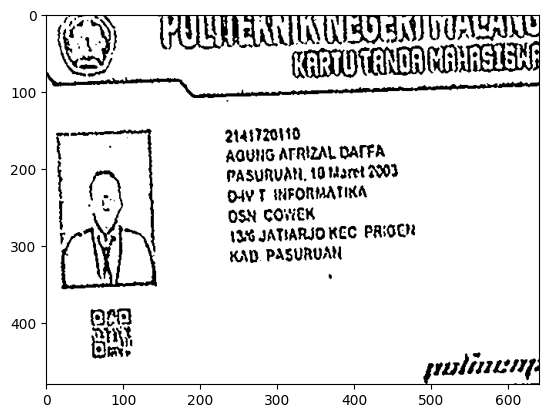

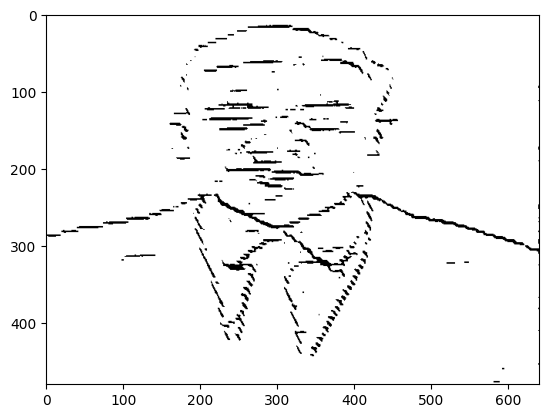

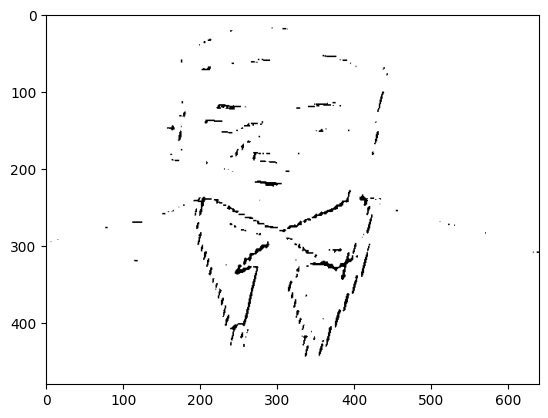

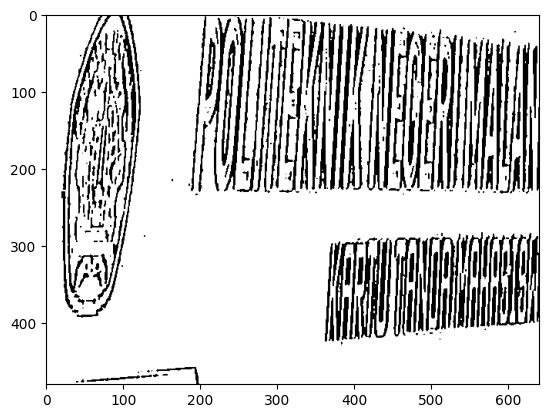

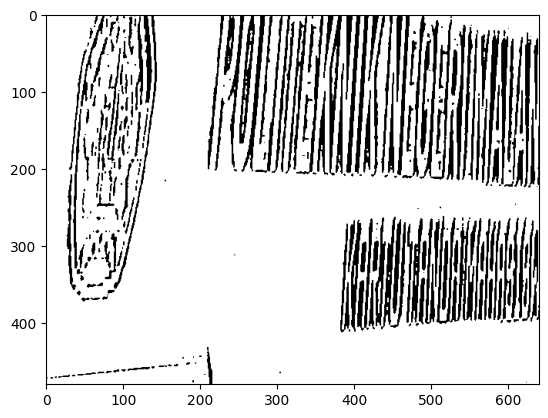

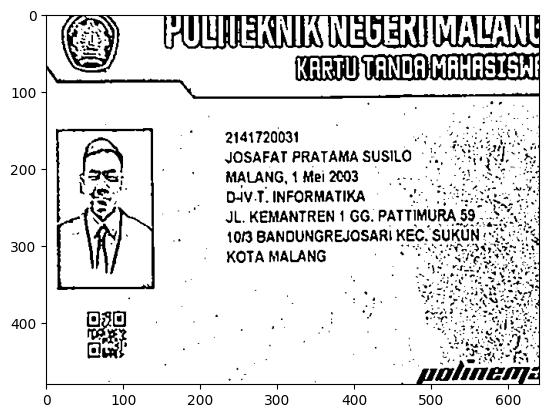

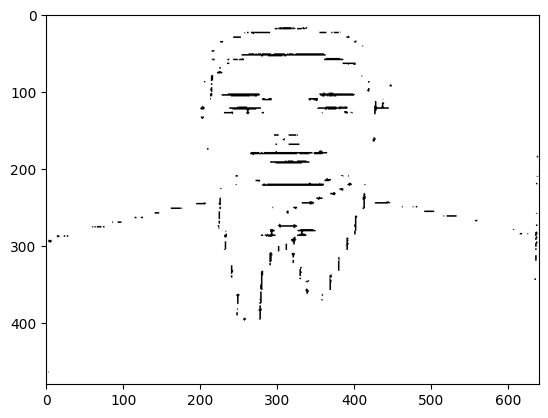

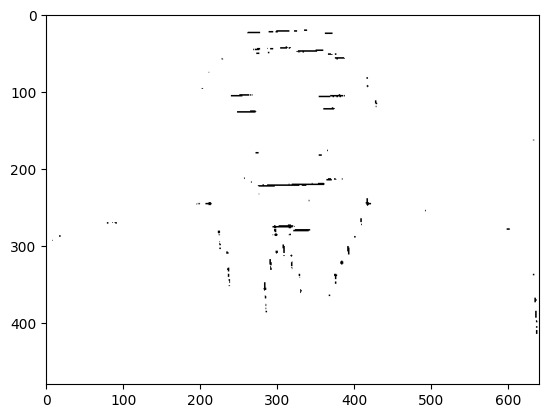

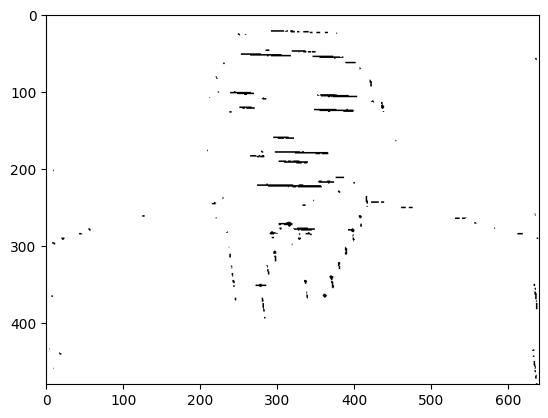

In [54]:
for success in successful_images:
  plt.figure()
  success_rgb = cv2.cvtColor(success, cv2.COLOR_GRAY2RGB)
  plt.imshow(success_rgb)
  plt.show()

**CNN MODEL**

In [6]:
from tensorflow.keras.datasets import mnist

In [7]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [8]:
(train_data.shape, test_data.shape)

((60000, 28, 28), (10000, 28, 28))

In [9]:
(train_labels.shape, test_labels.shape)

((60000,), (10000,))

In [10]:
train_data[0].shape

(28, 28)

In [11]:
train_labels.shape

(60000,)

**Combine Train and Test**

In [12]:
digits_data = np.vstack([train_data, test_data])
digits_labels = np.hstack([train_labels, test_labels])

In [13]:
digits_data.shape

(70000, 28, 28)

In [14]:
digits_labels.shape

(70000,)

Text(0.5, 1.0, 'Class: 8')

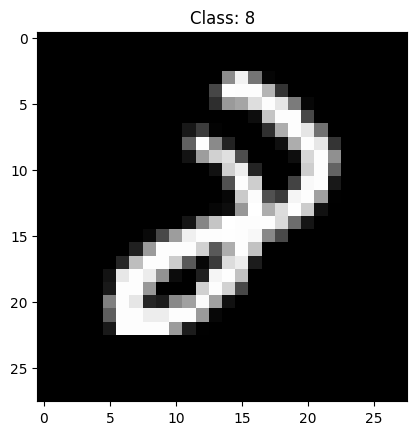

In [15]:
idx = np.random.randint(0, digits_data.shape[0])
plt.imshow(digits_data[idx], cmap='gray')
plt.title('Class: ' + str(digits_labels[idx]))

<Axes: xlabel='Labels', ylabel='count'>

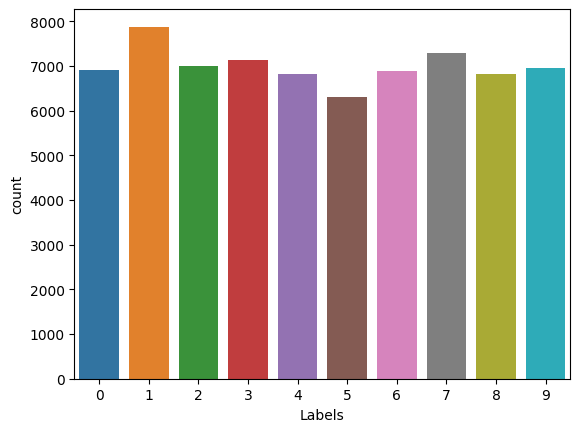

In [16]:
df_labels = pd.DataFrame(digits_labels, columns=['Labels'])
sns.countplot(df_labels, x='Labels')

**Load Kaggle**

In [17]:
!wget https://iaexpert.academy/arquivos/alfabeto_A-Z.zip

--2023-12-12 16:54:46--  https://iaexpert.academy/arquivos/alfabeto_A-Z.zip
Resolving iaexpert.academy (iaexpert.academy)... 162.159.134.42
Connecting to iaexpert.academy (iaexpert.academy)|162.159.134.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193643888 (185M) [application/zip]
Saving to: ‘alfabeto_A-Z.zip’

alfabeto_A-Z.zip    100%[===================>] 184.67M   188MB/s    in 1.0s    

2023-12-12 16:54:47 (188 MB/s) - ‘alfabeto_A-Z.zip’ saved [193643888/193643888]



In [18]:
zip_object = zipfile.ZipFile(file = 'alfabeto_A-Z.zip', mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [19]:
dataset_az = pd.read_csv('A_Z Handwritten Data.csv').astype('float32')
dataset_az

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372446,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372447,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372448,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Get pixel data only
alphabet_data = dataset_az.drop('0', axis=1)
# Get labels only
alphabet_labels = dataset_az['0']

In [21]:
# Check shape data
alphabet_data.shape, alphabet_labels.shape


((372450, 784), (372450,))

In [22]:
# Check shape labels
alphabet_labels.shape

(372450,)

In [23]:
# Reshape pixel data to 28*28
alphabet_data = np.reshape(alphabet_data.values, (alphabet_data.shape[0], 28, 28))
# Check the result by its shape
alphabet_data.shape

(372450, 28, 28)

Text(0.5, 1.0, 'Class: 20.0')

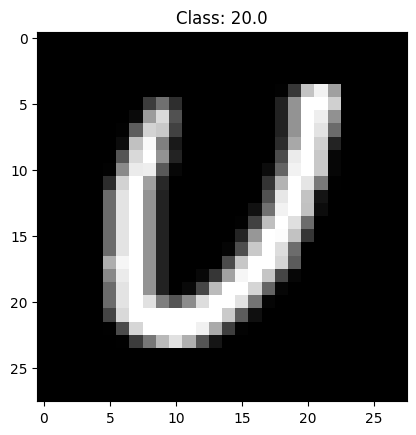

In [24]:
# Randomly checking A-Z dataset
index = np.random.randint(0, alphabet_data.shape[0])
plt.imshow(alphabet_data[index], cmap = 'gray')
plt.title('Class: ' + str(alphabet_labels[index]))

<Axes: xlabel='Labels', ylabel='count'>

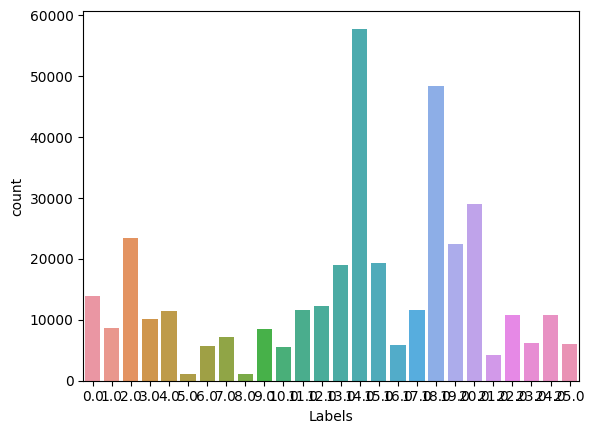

In [25]:
# Check data distribution
df_az_labels = pd.DataFrame({
    'Labels': alphabet_labels.values
})
sns.countplot(df_az_labels, x='Labels')

**Combine Mnist and Kaggle**

In [26]:
# Check unique value from digits_labels
np.unique(digits_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [27]:
# Check unique value from alphabet_labels
np.unique(alphabet_labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.],
      dtype=float32)

In [28]:
# We already know that digits labels containt labels from 0-9 (10 labels)
# We also know that alphabet labels start from 0-25 which represent A-Z
# If we want to combine them, the A-Z labels should continuing the digits label

alphabet_labels += 10

In [29]:
# check alphabet labels again
np.unique(alphabet_labels)

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
      dtype=float32)

In [30]:
# Combine both of them
data = np.vstack([alphabet_data, digits_data])
labels = np.hstack([alphabet_labels, digits_labels])

In [31]:
# Check the shape
data.shape, labels.shape

((442450, 28, 28), (442450,))

In [32]:
# Check labels
np.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35.], dtype=float32)

In [33]:
# Convert data to float32
data = np.array(data, dtype = 'float32')

In [34]:
# Since Convolutional need 3d data (including depth)
# and our images only in 2d data (because in grayscale format)
# we need to add "the depth" to the data
data = np.expand_dims(data, axis=-1)

# check shape
data.shape

(442450, 28, 28, 1)

**Pre-Processing**

In [35]:
# Normalize data
data /= 255.0

In [36]:
# Check range value of data
data[0].min(), data[0].max()

(0.0, 1.0)

In [37]:
# Enconde the labels
# LabelBinarizer similar with OneHotEncoder
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [38]:
# Check labels shape
labels.shape

(442450, 36)

Text(0.5, 1.0, '[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]')

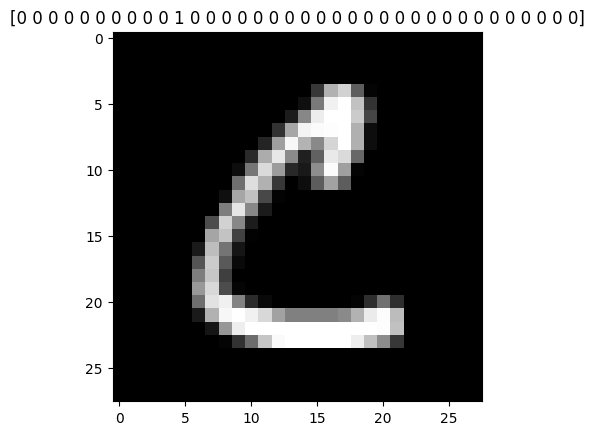

In [39]:
# Check data with label binarizer's label
plt.imshow(data[30000].reshape(28,28), cmap='gray')
plt.title(str(labels[0]))

In [40]:
# Since our data is not balance, we will handle it by giving weight for 'small' data

# Check number of data for each labels first
classes_total = labels.sum(axis = 0)
classes_total

array([ 6903,  7877,  6990,  7141,  6824,  6313,  6876,  7293,  6825,
        6958, 13869,  8668, 23409, 10134, 11440,  1163,  5762,  7218,
        1120,  8493,  5603, 11586, 12336, 19010, 57825, 19341,  5812,
       11566, 48419, 22495, 29008,  4182, 10784,  6272, 10859,  6076])

In [41]:
# Check the biggest value of data
classes_total.max()

57825

In [42]:
# Create a weight for each data
classes_weights = {}
for i in range(0, len(classes_total)):
  #print(i)
  classes_weights[i] = classes_total.max() / classes_total[i]

# Check the weight for each data
classes_weights

{0: 8.376792698826597,
 1: 7.340992763742541,
 2: 8.272532188841202,
 3: 8.097605377398123,
 4: 8.473769050410317,
 5: 9.15967052114684,
 6: 8.409685863874346,
 7: 7.928835870012341,
 8: 8.472527472527473,
 9: 8.310577752227651,
 10: 4.169370538611291,
 11: 6.671089063221043,
 12: 2.4702037677816224,
 13: 5.7060390763765545,
 14: 5.0546328671328675,
 15: 49.72055030094583,
 16: 10.035577924331829,
 17: 8.011221945137157,
 18: 51.629464285714285,
 19: 6.808548216178029,
 20: 10.320364090665715,
 21: 4.990937338166753,
 22: 4.6875,
 23: 3.0418200946870066,
 24: 1.0,
 25: 2.989762680316426,
 26: 9.94924294562973,
 27: 4.999567698426422,
 28: 1.1942625828703608,
 29: 2.5705712380529007,
 30: 1.993415609487038,
 31: 13.827116212338593,
 32: 5.362110534124629,
 33: 9.21954719387755,
 34: 5.3250759738465785,
 35: 9.51695194206715}

**Split Data to Train and Test**

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 1, stratify = labels)

**Create Data Augmentation**

In [44]:
# Import library
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [45]:
augmentation = ImageDataGenerator(rotation_range = 10, zoom_range=0.05, width_shift_range=0.1,
                                  height_shift_range=0.1, horizontal_flip = False)

**Build CNN Model**

In [46]:
# Import library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [51]:
# Build the network
network = Sequential()

network.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu', padding='same'))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu', padding='valid'))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Flatten())

network.add(Dense(64, activation = 'relu'))
network.add(Dense(128, activation = 'relu'))

# output
network.add(Dense(36, activation='softmax'))

network.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [55]:
# Check network summary
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [56]:
# Create actual labels
name_labels = '0123456789'
name_labels += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
name_labels = [l for l in name_labels]

# Check actual label
print(name_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [57]:
import joblib

joblib.dump(name_labels, "labels.pkl")

['labels.pkl']

In [58]:
a = joblib.load("labels.pkl")
print(a)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


**Train Model**

In [59]:
# Set model name, epoch, and batch size
file_model = 'custom_ocr.model'
epochs = 20
batch_size = 128

In [60]:
# Setup checkpoint
checkpointer = ModelCheckpoint(file_model, monitor = 'val_loss', verbose = 1, save_best_only=True)

In [61]:
# Fit the model
history = network.fit(augmentation.flow(X_train, y_train, batch_size=batch_size),
                      validation_data = (X_test, y_test),
                      steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                      class_weight = classes_weights, verbose=1, callbacks=[checkpointer])

Epoch 1/20
2765/2765 [==============================] - ETA: 0s - loss: 2.2590 - accuracy: 0.8231
Epoch 1: val_loss improved from inf to 0.21588, saving model to custom_ocr.model
2765/2765 [==============================] - 159s 53ms/step - loss: 2.2590 - accuracy: 0.8231 - val_loss: 0.2159 - val_accuracy: 0.9297
Epoch 2/20
2765/2765 [==============================] - ETA: 0s - loss: 1.0131 - accuracy: 0.8982
Epoch 2: val_loss did not improve from 0.21588
2765/2765 [==============================] - 133s 48ms/step - loss: 1.0131 - accuracy: 0.8982 - val_loss: 0.2831 - val_accuracy: 0.8772
Epoch 3/20
2765/2765 [==============================] - ETA: 0s - loss: 0.8276 - accuracy: 0.9119
Epoch 3: val_loss improved from 0.21588 to 0.20666, saving model to custom_ocr.model
2765/2765 [==============================] - 136s 49ms/step - loss: 0.8276 - accuracy: 0.9119 - val_loss: 0.2067 - val_accuracy: 0.9149
Epoch 4/20
2765/2765 [==============================] - ETA: 0s - loss: 0.7447 - accu

**Evaluate Model**

**Make a single prediction**

In [62]:
# make a prediction
load_network = load_model('custom_ocr.model')
predictions = load_network.predict(X_test, batch_size=batch_size)

692/692 [==============================] - 2s 3ms/step


In [63]:
# Check prediction for data-0
# You will get the probability for each label
# The highest one is the prediction
predictions[10]


array([1.08636877e-08, 4.89449236e-12, 3.95410857e-11, 2.05671813e-09,
       2.37173670e-10, 3.69068049e-02, 1.82508529e-07, 7.22096048e-13,
       1.07091225e-08, 2.69773477e-06, 3.30688545e-17, 7.61868435e-09,
       1.40139740e-08, 3.93354460e-10, 1.95915853e-11, 9.74336104e-14,
       1.73652404e-06, 5.75407613e-17, 2.33766503e-15, 1.97685836e-06,
       3.88376176e-09, 4.34268443e-09, 2.67192859e-15, 4.00574925e-15,
       6.22384899e-09, 8.60047200e-10, 5.69659386e-09, 3.68131319e-15,
       9.63086665e-01, 2.12386678e-10, 3.41760092e-10, 4.70084854e-13,
       1.24653838e-11, 1.10097455e-16, 1.22117805e-09, 1.16273797e-14],
      dtype=float32)

In [64]:
# Get the actual prediction -> highest probability
np.argmax(predictions[10])

28

In [65]:
# Check label for 24
name_labels[28]

'S'

In [66]:
# Check y_test label for 0
y_test[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [67]:
# check the highest value
np.argmax(y_test[10])


28

In [68]:
# Check the label of y_test 0
name_labels[np.argmax(y_test[10])]

'S'

**Make an Evaluation on Test Data**

In [69]:
# Evaluate on test data
load_network.evaluate(X_test, y_test)

2766/2766 [==============================] - 10s 4ms/step - loss: 0.1405 - accuracy: 0.9514


[0.14051657915115356, 0.9514182209968567]

In [70]:
# Print Classification Report
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = name_labels))

              precision    recall  f1-score   support

           0       0.35      0.64      0.46      1381
           1       0.97      0.99      0.98      1575
           2       0.88      0.98      0.93      1398
           3       0.94      1.00      0.97      1428
           4       0.89      0.98      0.93      1365
           5       0.69      0.94      0.80      1263
           6       0.95      0.98      0.97      1375
           7       0.94      0.99      0.97      1459
           8       0.97      0.99      0.98      1365
           9       0.98      0.97      0.97      1392
           A       1.00      0.99      0.99      2774
           B       0.98      0.99      0.98      1734
           C       0.99      0.99      0.99      4682
           D       0.89      0.98      0.93      2027
           E       0.99      0.99      0.99      2288
           F       0.96      0.99      0.97       233
           G       0.98      0.94      0.96      1152
           H       0.98    

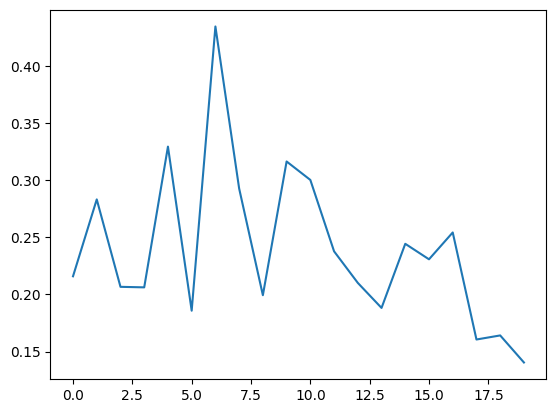

In [71]:
# Visualize loss value for each epoch
plt.plot(history.history['val_loss'])


In [72]:
# You can also check the another metrics
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

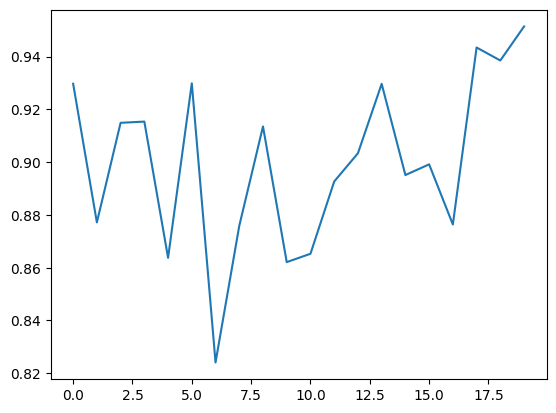

In [73]:
# Check the model performance by validation accuracy
plt.plot(history.history['val_accuracy'])

**Save the Model**

In [74]:
# The result will show in colab directory
network.save('network', save_format= 'h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Testing on Real Image**

In [75]:
import numpy as np
import imutils
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow

In [76]:
# Load saved network
load_network = load_model('network')

In [77]:
# Check summary
load_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

1/1 [==============================] - 0s 16ms/step
T 

ValueError: ignored

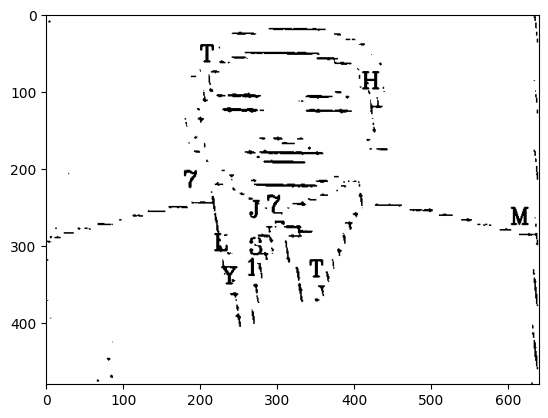

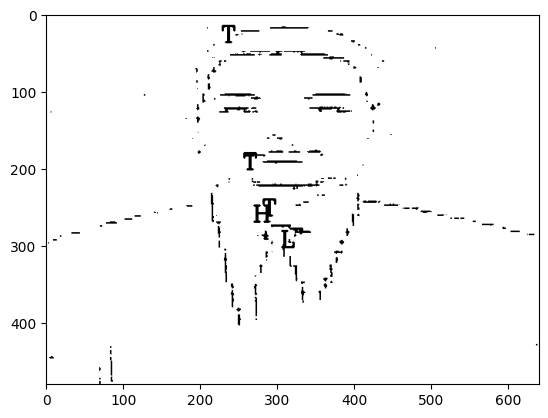

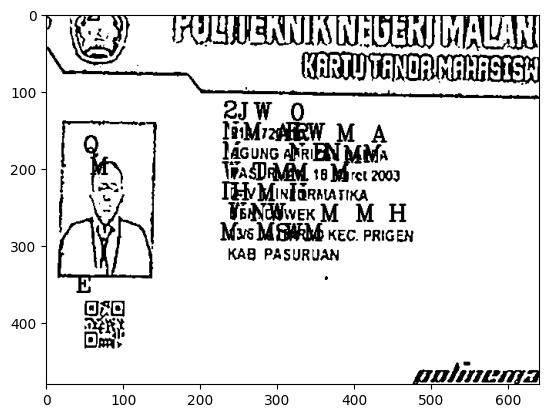

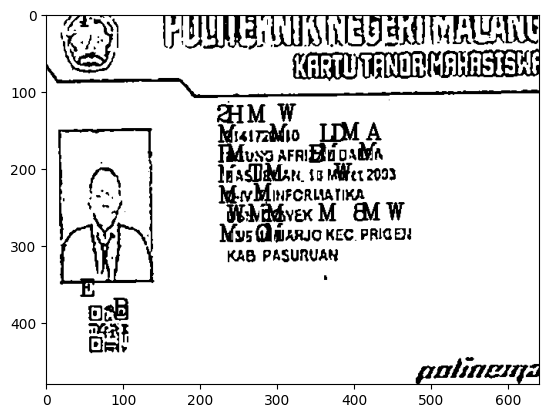

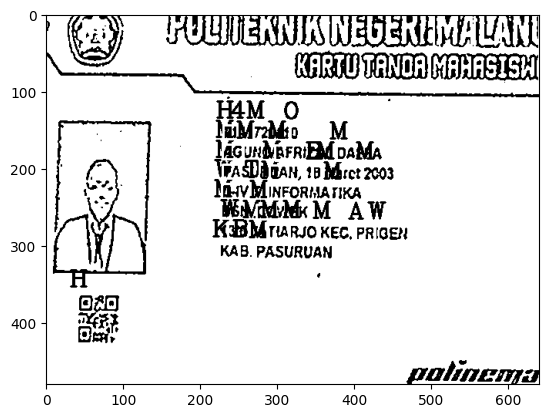

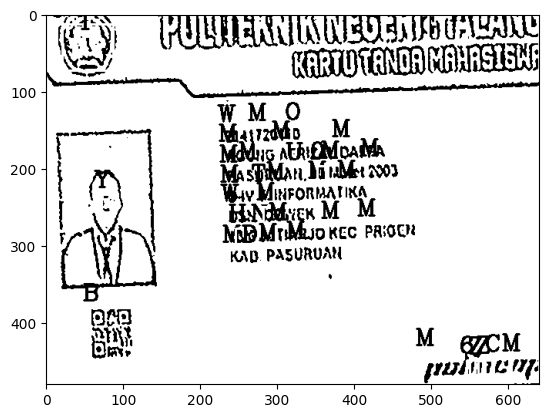

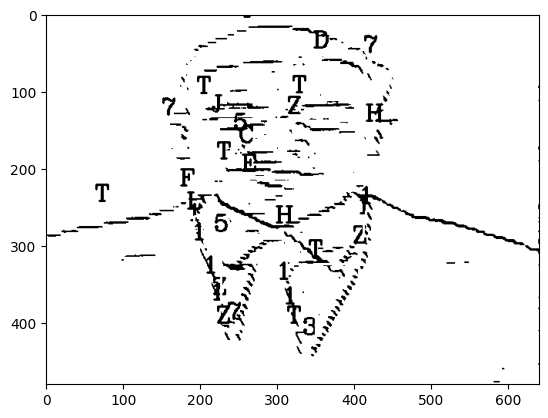

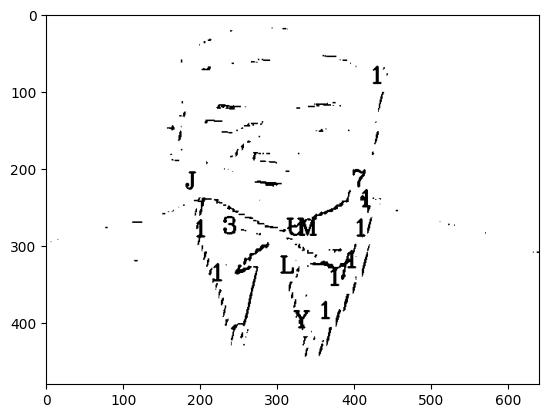

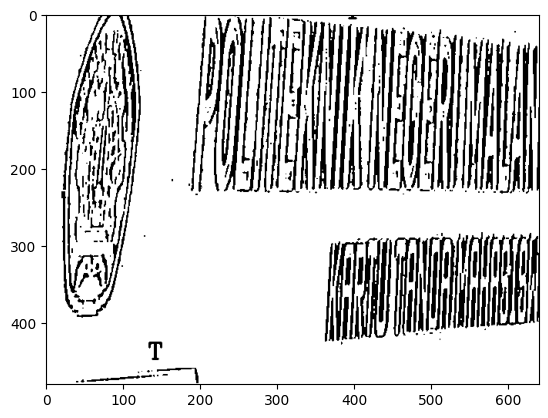

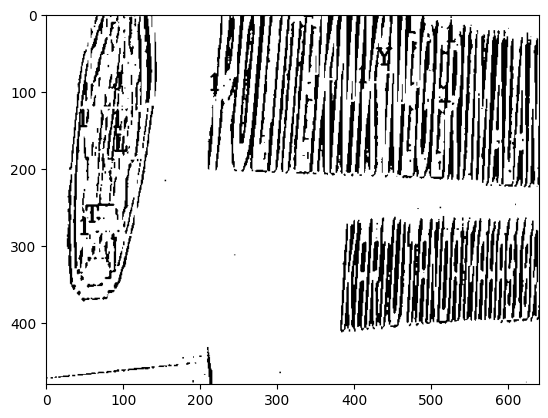

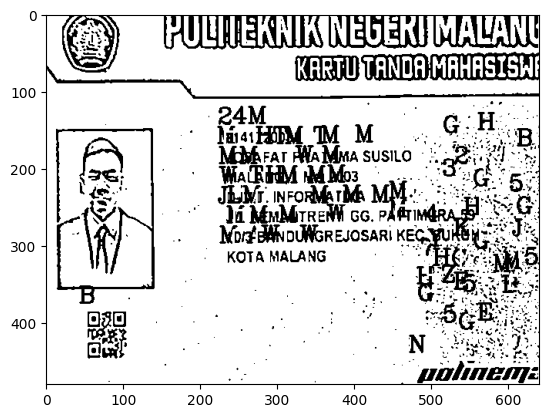

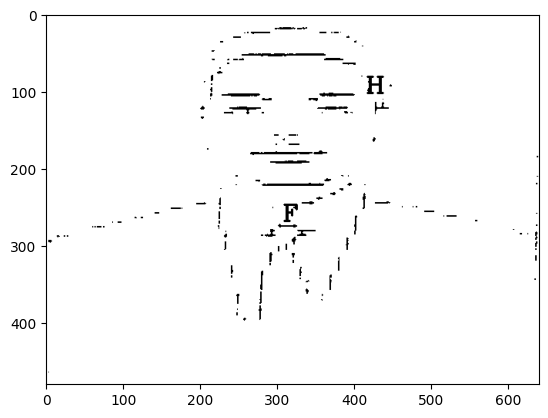

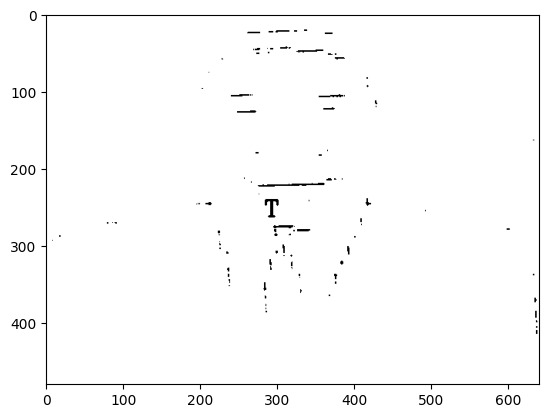

In [79]:
for success in successful_images:
  invertion = 255 - success
  dilation = cv2.dilate(invertion, np.ones((3,3)))
  edges = cv2.Canny(dilation, 40, 150)

  def find_contours(img):
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sort_contours(conts, method='left-to-right')[0]
    return conts

  conts = find_contours(dilation.copy())

  min_w, max_w = 10, 160
  min_h, max_h = 14, 140
  img_copy = success.copy()

  for c in conts:
    (x, y, w, h) = cv2.boundingRect(c) # find bounding box based on contour
    # if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
    roi = success[y:y+h, x:x+w] # get region of interest for char
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Build bounding box on original image
    cv2.rectangle(img_copy, (x,y), (x+w, y+h), (255,0,0), 2)

  min_w, max_w = 10, 160
  min_h, max_h = 14, 140
  img_copy = success.copy()

  for c in conts:
    (x, y, w, h) = cv2.boundingRect(c) # find bounding box based on contour
    # if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
    roi = success[y:y+h, x:x+w] # get region of interest for char
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Build bounding box on original image
    cv2.rectangle(img_copy, (x,y), (x+w, y+h), (255,0,0), 2)

  def extract_roi(img):
    roi = img[y:y+h, x:x+w]
    return roi

  def thresholding(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

  def resize_img(img, w, h):
    if w > h:
      resized = imutils.resize(img, width=28)
    else:
      resized = imutils.resize(img, height=28)

    # (w, h) = resized.shape
    (h, w) = resized.shape

    # Calculate how many pixels need to fill char image
    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)

    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    filled = cv2.resize(filled, (28,28))

    return filled

  (x, y, w, h) = cv2.boundingRect(conts[1])
  test_image = thresholding(success[y:y+h, x:x+w])

  (h, w) = test_image.shape
  test_image2 = resize_img(test_image, w, h)

  def normalization(img):
    img = img.astype('float32') / 255.0 # convert to floating point
    img = np.expand_dims(img, axis=-1) # add depth
    return img

  test_image2.shape, normalization(test_image2).shape

  def process_box(gray, x, y, w, h):
    roi = extract_roi(gray)
    thresh = thresholding(roi)
    (h, w) = thresh.shape
    resized = resize_img(thresh, w, h)
    normalized = normalization(resized)
    return (normalized, (x, y, w, h))

  detected_char = []

  for c in conts:
    (x, y, w, h ) = cv2.boundingRect(c)
    min_w, max_w = 10, 160
    min_h, max_h = 14, 140
    if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
      detected_char.append(process_box(success, x, y, w, h))

  pixels = np.array([px[0] for px in detected_char], dtype='float32')
  # Get all box for detected char
  boxes = [box[1] for box in detected_char]

  digits = '0123456789'
  letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
  char_list = digits + letters
  char_list = [ch for ch in char_list]

  preds = network.predict(pixels)

  for p in preds:
    char_idx = np.argmax(p)
    print(char_list[char_idx], end = " ")

  img_copy2 = success.copy()

  for(pred, (x, y, w, h)) in zip(preds, boxes):
    i = np.argmax(pred)
    char_detected = char_list[i]

    cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (255,0,0), 2)
    cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

  plt.figure()
  img_copy2_rgb = cv2.cvtColor(img_copy2, cv2.COLOR_GRAY2RGB)
  plt.imshow(img_copy2_rgb)

plt.show()


**Mencoba Tes pada gambar crop manual**